# VGG-16

## Install Libraries

In [1]:
%pip install tensorflow tensorflow-datasets matplotlib pydot


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

2024-07-16 03:49:48.009892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 03:49:48.014290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 03:49:48.026958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 03:49:48.045768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 03:49:48.051212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 03:49:48.065992: I tensorflow/core/platform/cpu_feature_gu

## Load Data

In [3]:
(train_data, test_data), info = tfds.load('cifar10',
                                          split=('train[:40%]', 'train[40%:50%]'),
                                          with_info=True,
                                          as_supervised=True)

## Data Exploration

In [4]:
len(train_data), len(test_data)

(20000, 5000)

In [5]:
for X, y in train_data:
    print(X.shape, y.numpy())
    image_1 = X.numpy()
    break

(32, 32, 3) 7


2024-07-16 03:49:51.001904: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


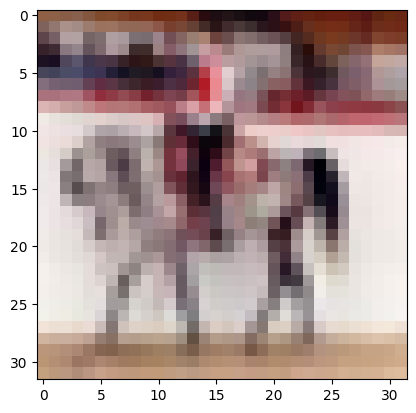

In [6]:
plt.imshow(image_1)

## Preprocess Data

In [7]:
def normalize_img(image, label):
    return ((tf.cast(image, tf.float32)) / 255.0, label)

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

def augment(image, label):
    return data_augmentation(image), label

In [8]:
train_data = train_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
SHUFFLE_VAL = len(train_data) // 1000
BATCH_SIZE = 32

train_data = train_data.shuffle(SHUFFLE_VAL)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [10]:
test_data = test_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

## Building the Model

In [11]:
model = Sequential(layers=[
    Input(shape=(32, 32, 3)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=4096, activation='relu'),
    Dense(units=10, activation='softmax'),
])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,80

 Total params: 33,051,722 (126.08 MB)

 Trainable params: 33,049,930 (126.08 MB)

 Non-trainable params: 1,792 (7.00 KB)

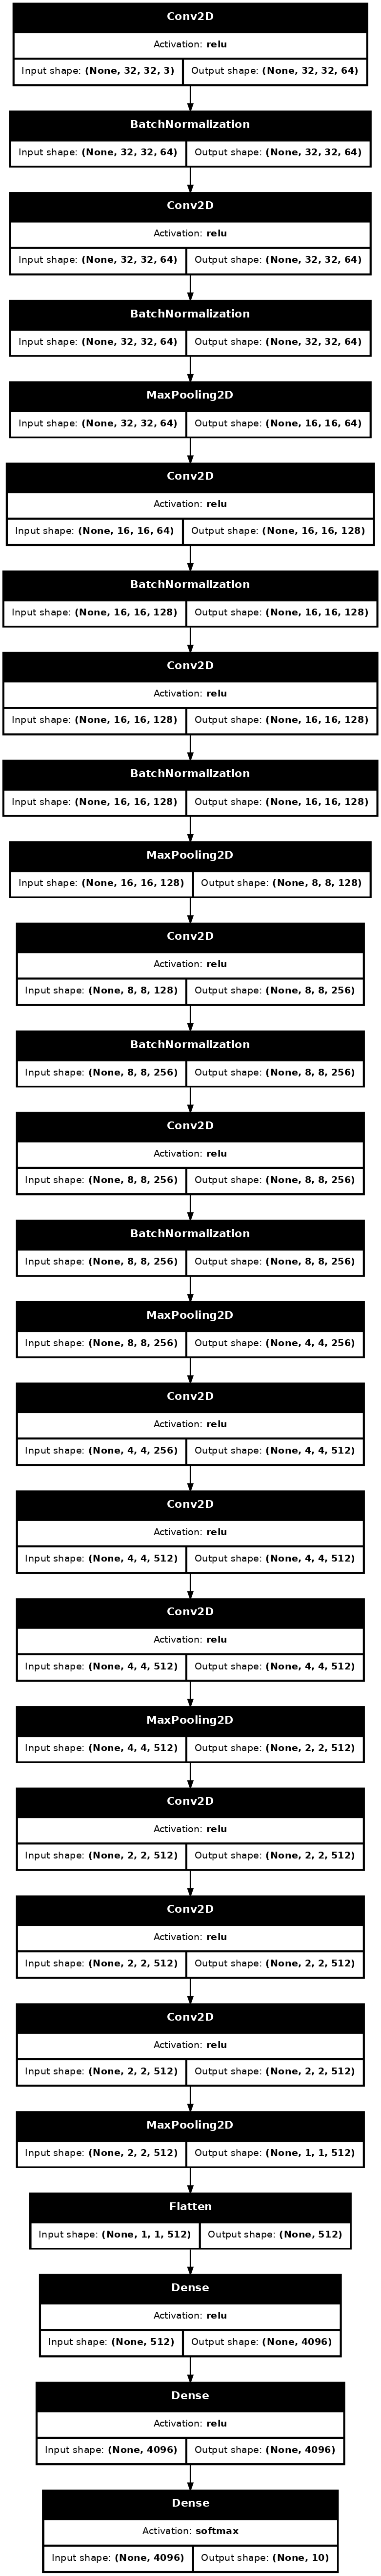

In [13]:
plot_model(model,
           to_file='./images/model_architecture.png',
           show_shapes=True,
           show_dtype=False,
           show_layer_names=False,
           show_layer_activations=True,
           dpi=100)

In [14]:
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
es = EarlyStopping(patience=10,
                   monitor='val_loss',
                   restore_best_weights=True)

In [16]:
history = model.fit(train_data,
                    epochs=50,
                    validation_data=test_data,
                    callbacks=[es])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 775s 1s/step - accuracy: 0.1933 - loss: 17.1493 - val_accuracy: 0.2428 - val_loss: 3.5041
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 877s 1s/step - accuracy: 0.2826 - loss: 3.1890 - val_accuracy: 0.3048 - val_loss: 2.6450
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.3458 - loss: 2.5444 - val_accuracy: 0.4042 - val_loss: 2.2255
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 804s 1s/step - accuracy: 0.3872 - loss: 2.2726 - val_accuracy: 0.4134 - val_loss: 2.1193
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - accuracy: 0.4097 - loss: 2.1299 - val_accuracy: 0.4834 - val_loss: 1.9029
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 817s 1s/step - accuracy: 0.4478 - loss: 1.9914 - val_accuracy: 0.4942 - val_loss: 1.8321
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 809s 1s/step - accuracy: 0.4830 - loss: 1.8765 - val_accuracy: 0.5296 - val_loss: 1.7449
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.5141 - loss: 1.7923 - val_acc

## Plot Training History

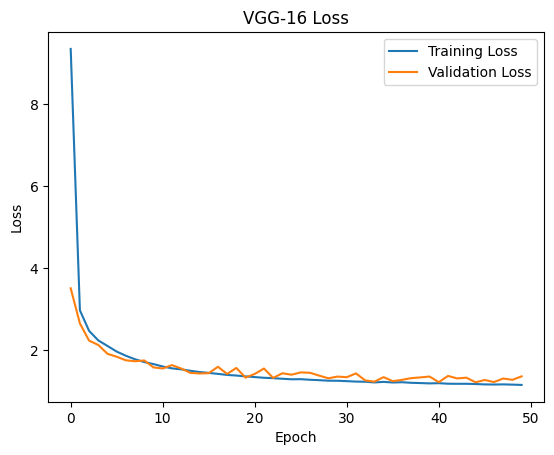

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('VGG-16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

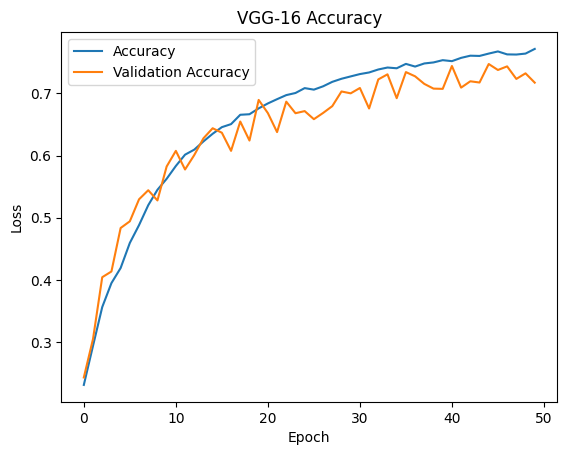

In [22]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('VGG-16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()